In [1]:
# Let's import the required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from collections import Counter
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer


import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from nltk import pos_tag

import warnings 
warnings.filterwarnings('ignore')

In [2]:
amazon=pd.read_csv("Amazon_ratings_final.csv")
amazon

,Unnamed: 0,Ratings,Reviews
0,0,3.0 out of 5 stars,\n\n\n\n\n\n\n\n\n \n Your browser does not ...
1,1,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Laptop get...
2,2,3.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n It looks t...
3,3,3.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n How to ins...
4,4,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n HiThis is ...
...,...,...,...
11597,1022,4.0 out of 5 stars,Pros:-\n1. The Watch has great battery life ca...
11598,1023,5.0 out of 5 stars,I have been using this watch since 14 days. Ba...
11599,1024,4.0 out of 5 stars,PROS : GOOD BATTERY LIFE 🔋\nAmazing touch feed...
11600,1025,4.0 out of 5 stars,"This was my first smartwatch, and I was very e..."


In [3]:
#cleaning whitespaces, slicing columns to keep only necessary data
amazon = amazon.replace('\n','', regex=True)
amazon['Ratings']=amazon['Ratings'].str.slice(0,1)
amazon.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
amazon.head()

,Ratings,Reviews
0,3,Your browser does not support HTML5 video....
1,1,Laptop getting hang very much and ve...
2,3,It looks the screen size is small . ...
3,3,How to install a new SSD? The SSD do...
4,1,"HiThis is a true feedback, requestin..."


In [5]:
flipkart=pd.read_csv("flipkart_ratings_final.csv")
flipkart

,Unnamed: 0,Ratings,Reviews
0,0,4,Product is good but the fan is running continu...
1,1,5,It's just amazing! Let me get the details here...
2,2,5,Very good It's a beast at the price of 40k Lov...
3,3,5,It's amazing! Best is this category. I just bo...
4,4,4,Thanks Flipkart for fast delivery in our lockd...
...,...,...,...
60500,17295,5,This is varrast product
60501,17296,1,Worst product no sound quality and not connect...
60502,17297,5,Super 👌
60503,17298,1,Very bad very very bad remote is not working bad


In [6]:
flipkart.drop('Unnamed: 0',axis=1,inplace=True)
flipkart = flipkart.replace('\n',' ', regex=True)

In [7]:
flipkart.head()

,Ratings,Reviews
0,4,Product is good but the fan is running continu...
1,5,It's just amazing! Let me get the details here...
2,5,Very good It's a beast at the price of 40k Lov...
3,5,It's amazing! Best is this category. I just bo...
4,4,Thanks Flipkart for fast delivery in our lockd...


In [8]:
#joining both data frames to create a single dataframe
ds=pd.concat([amazon,flipkart])
ds['Ratings']=(ds['Ratings']).astype(int)

In [9]:
ds

,Ratings,Reviews
0,3,Your browser does not support HTML5 video....
1,1,Laptop getting hang very much and ve...
2,3,It looks the screen size is small . ...
3,3,How to install a new SSD? The SSD do...
4,1,"HiThis is a true feedback, requestin..."
...,...,...
60500,5,This is varrast product
60501,1,Worst product no sound quality and not connect...
60502,5,Super 👌
60503,1,Very bad very very bad remote is not working bad


In [10]:
ds.isnull().sum()

Ratings    0
Reviews    0
dtype: int64

In [11]:
ds["Ratings"].value_counts()

5    39257
4    13557
1     9480
3     5073
2     4740
Name: Ratings, dtype: int64

In [12]:
rating5 = ds[ds['Ratings'] == 5][:4740]
rating4 = ds[ds['Ratings'] == 4][:4740]
rating3 = ds[ds['Ratings'] == 3][:4740]
rating2 = ds[ds['Ratings'] == 2][:4740]
rating1 = ds[ds['Ratings'] == 1][:4740]

ds_Final=pd.concat([rating5,rating4,rating3,rating2,rating1],axis=0,ignore_index=True)
ds_Final

,Ratings,Reviews
0,5,Hp laptop with intel less than 40k.A...
1,5,A really good laptop for online clas...
2,5,Good laptop for day to day work .. i...
3,5,Likes:Best laptop under 50k budget.L...
4,5,I bought this exchanging my Acer Asp...
...,...,...
23695,1,It's very awful experience with the brand like...
23696,1,"Sound Quality is Good , Battery Back is good ,..."
23697,1,Received the product in good shape. Very good ...
23698,1,Bad product didn't work Requests not accepted...


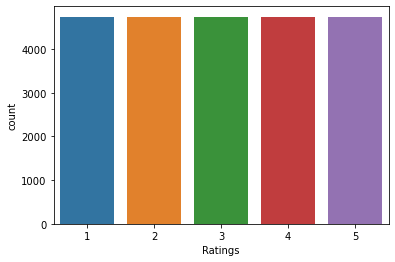

In [13]:
#visualizing the Rating column 
sns.countplot(ds_Final['Ratings'])
plt.show()

In [14]:
# 1. Remove HTML tags
#Regex rule : ‘<.*?>’

def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned,'',text) # substring replace with ''(space)

ds_Final.Reviews = ds_Final.Reviews.apply(clean)
ds_Final.Reviews

0                  Hp laptop with intel less than 40k.A...
1                  A really good laptop for online clas...
2                  Good laptop for day to day work .. i...
3                  Likes:Best laptop under 50k budget.L...
4                  I bought this exchanging my Acer Asp...
                               ...                        
23695    It's very awful experience with the brand like...
23696    Sound Quality is Good , Battery Back is good ,...
23697    Received the product in good shape. Very good ...
23698    Bad product didn't work  Requests not accepted...
23699                                       It is very bad
Name: Reviews, Length: 23700, dtype: object

In [15]:
# 2. Remove special characters
def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem

ds_Final.Reviews =ds_Final.Reviews.apply(is_special)
ds_Final.Reviews

0                  Hp laptop with intel less than 40k A...
1                  A really good laptop for online clas...
2                  Good laptop for day to day work    i...
3                  Likes Best laptop under 50k budget L...
4                  I bought this exchanging my Acer Asp...
                               ...                        
23695    It s very awful experience with the brand like...
23696    Sound Quality is Good   Battery Back is good  ...
23697    Received the product in good shape  Very good ...
23698    Bad product didn t work  Requests not accepted...
23699                                       It is very bad
Name: Reviews, Length: 23700, dtype: object

In [16]:
# 3. Convert everything to lowercase
def to_lower(text):
    return text.lower()

ds_Final.Reviews = ds_Final.Reviews.apply(to_lower)
ds_Final.Reviews

0                  hp laptop with intel less than 40k a...
1                  a really good laptop for online clas...
2                  good laptop for day to day work    i...
3                  likes best laptop under 50k budget l...
4                  i bought this exchanging my acer asp...
                               ...                        
23695    it s very awful experience with the brand like...
23696    sound quality is good   battery back is good  ...
23697    received the product in good shape  very good ...
23698    bad product didn t work  requests not accepted...
23699                                       it is very bad
Name: Reviews, Length: 23700, dtype: object

In [17]:
# Replace email addresses with 'email'
ds_Final['Reviews'] = ds_Final['Reviews'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                     'emailaddress')

    # Replace URLs with 'webaddress'
ds_Final['Reviews'] = ds_Final['Reviews'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                      'webaddress')

    # Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
ds_Final['Reviews'] = ds_Final['Reviews'].str.replace(r'£|\$', 'dollers')

    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
ds_Final['Reviews'] = ds_Final['Reviews'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                      'phonenumber')


    # Replace numbers with 'numbr'
ds_Final['Reviews'] = ds_Final['Reviews'].str.replace(r'\d+(\.\d+)?', 'numbr')

    # Remove punctuation
ds_Final['Reviews'] = ds_Final['Reviews'].str.replace(r'[^\w\d\s]', ' ')

    # Replace whitespace between terms with a single space
ds_Final['Reviews'] = ds_Final['Reviews'].str.replace(r'\s+', ' ')

    # Remove leading and trailing whitespace
ds_Final['Reviews'] = ds_Final['Reviews'].str.replace(r'^\s+|\s+?$', '')

In [18]:
# 4. Remove stopwords
def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words]

ds_Final.Reviews = ds_Final.Reviews.apply(rem_stopwords)
ds_Final.Reviews

0        [hp, laptop, intel, less, numbrk, starting, mu...
1        [really, good, laptop, online, classes, well, ...
2        [good, laptop, day, day, work, inumbr, numbrgb...
3        [likes, best, laptop, numbrk, budget, light, w...
4        [bought, exchanging, acer, aspire, vnumbr, int...
                               ...                        
23695    [awful, experience, brand, like, boat, boat, r...
23696    [sound, quality, good, battery, back, good, de...
23697    [received, product, good, shape, good, sound, ...
23698    [bad, product, work, requests, accepted, excha...
23699                                                [bad]
Name: Reviews, Length: 23700, dtype: object

# Stemming

In [19]:
from nltk.stem import SnowballStemmer, WordNetLemmatizer
stemmer = SnowballStemmer("english")
import gensim
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))

In [20]:
#Tokenize and Lemmatize
def preprocess(text):
    result=[]
    for token in text:
        if len(token)>=3:
            result.append(lemmatize_stemming(token))
            
    return result

In [21]:
# Processing review with above Function
processed_review = []

for doc in ds_Final.Reviews:
    processed_review.append(preprocess(doc))
    
print(len(processed_review))
processed_review[:3]

23700


[['laptop',
  'intel',
  'less',
  'numbrk',
  'start',
  'much',
  'slow',
  'updat',
  'work',
  'fine',
  'hint',
  'keyboard',
  'backlit',
  'numlock',
  'indic',
  'screen',
  'good',
  'read'],
 ['realli',
  'good',
  'laptop',
  'onlin',
  'class',
  'well',
  'game',
  'worth',
  'money',
  'screen',
  'length',
  'height',
  'perfect',
  'one',
  'problem',
  'port',
  'wire',
  'earphon',
  'bluetooth',
  'one',
  'read'],
 ['good',
  'laptop',
  'day',
  'day',
  'work',
  'inumbr',
  'numbrgb',
  'ssd',
  'make',
  'smooth',
  'recommend',
  'gamer',
  'casual',
  'game',
  'offic',
  'numbr',
  'lifetim',
  'licens',
  'say',
  'batteri',
  'life',
  'buy',
  'game',
  'video',
  'edit',
  'dedic',
  'graphic',
  'card',
  'laptop',
  'get',
  'numbrk',
  'good',
  'deal',
  'let',
  'use',
  'day',
  'post',
  'review',
  'read']]

In [22]:
ds_Final.Reviews

0        [hp, laptop, intel, less, numbrk, starting, mu...
1        [really, good, laptop, online, classes, well, ...
2        [good, laptop, day, day, work, inumbr, numbrgb...
3        [likes, best, laptop, numbrk, budget, light, w...
4        [bought, exchanging, acer, aspire, vnumbr, int...
                               ...                        
23695    [awful, experience, brand, like, boat, boat, r...
23696    [sound, quality, good, battery, back, good, de...
23697    [received, product, good, shape, good, sound, ...
23698    [bad, product, work, requests, accepted, excha...
23699                                                [bad]
Name: Reviews, Length: 23700, dtype: object

In [23]:
#Creating a new feature Processed_Review which has all the reviewsw after all the pre-processing steps
ds_Final['Processed_review']=processed_review

In [24]:
ds_Final

,Ratings,Reviews,Processed_review
0,5,"[hp, laptop, intel, less, numbrk, starting, mu...","[laptop, intel, less, numbrk, start, much, slo..."
1,5,"[really, good, laptop, online, classes, well, ...","[realli, good, laptop, onlin, class, well, gam..."
2,5,"[good, laptop, day, day, work, inumbr, numbrgb...","[good, laptop, day, day, work, inumbr, numbrgb..."
3,5,"[likes, best, laptop, numbrk, budget, light, w...","[like, best, laptop, numbrk, budget, light, we..."
4,5,"[bought, exchanging, acer, aspire, vnumbr, int...","[buy, exchang, acer, aspir, vnumbr, intel, inu..."
...,...,...,...
23695,1,"[awful, experience, brand, like, boat, boat, r...","[aw, experi, brand, like, boat, boat, rockerz,..."
23696,1,"[sound, quality, good, battery, back, good, de...","[sound, qualiti, good, batteri, back, good, de..."
23697,1,"[received, product, good, shape, good, sound, ...","[receiv, product, good, shape, good, sound, ef..."
23698,1,"[bad, product, work, requests, accepted, excha...","[bad, product, work, request, accept, exchang]"


In [25]:
ds_Final['Reviews'] = ds_Final['Processed_review'].apply(lambda x:' '.join(y for y in x))

In [26]:
ds_Final

,Ratings,Reviews,Processed_review
0,5,laptop intel less numbrk start much slow updat...,"[laptop, intel, less, numbrk, start, much, slo..."
1,5,realli good laptop onlin class well game worth...,"[realli, good, laptop, onlin, class, well, gam..."
2,5,good laptop day day work inumbr numbrgb ssd ma...,"[good, laptop, day, day, work, inumbr, numbrgb..."
3,5,like best laptop numbrk budget light weight la...,"[like, best, laptop, numbrk, budget, light, we..."
4,5,buy exchang acer aspir vnumbr intel inumbr lap...,"[buy, exchang, acer, aspir, vnumbr, intel, inu..."
...,...,...,...
23695,1,aw experi brand like boat boat rockerz headset...,"[aw, experi, brand, like, boat, boat, rockerz,..."
23696,1,sound qualiti good batteri back good design go...,"[sound, qualiti, good, batteri, back, good, de..."
23697,1,receiv product good shape good sound effect li...,"[receiv, product, good, shape, good, sound, ef..."
23698,1,bad product work request accept exchang,"[bad, product, work, request, accept, exchang]"


# Displaying loud words in each rating using Word Cloud

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [29]:
def Display_wordcloud(data,title):
    feedbackcloud = WordCloud(
        background_color = 'black',
        max_words = 1000,
        max_font_size = 40, 
        scale = 3,
        random_state = 25
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15, 10),facecolor='g')
    plt.axis('off')
    plt.imshow(feedbackcloud)
    plt.title(f"{title} words")
    plt.show()

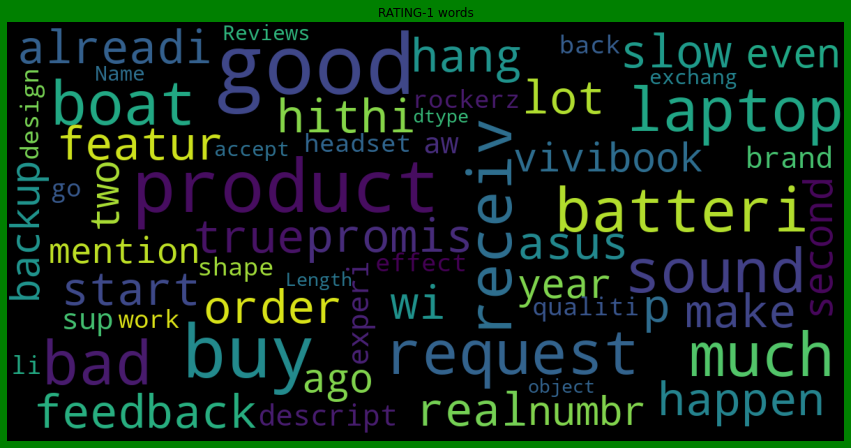

In [30]:
Display_wordcloud(ds_Final['Reviews'][ds_Final['Ratings']==1],"RATING-1")

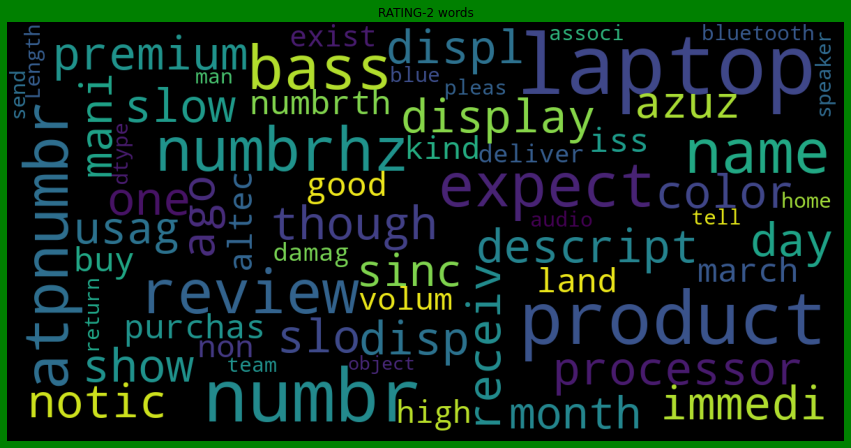

In [31]:
Display_wordcloud(ds_Final['Reviews'][ds_Final['Ratings']==2],"RATING-2")

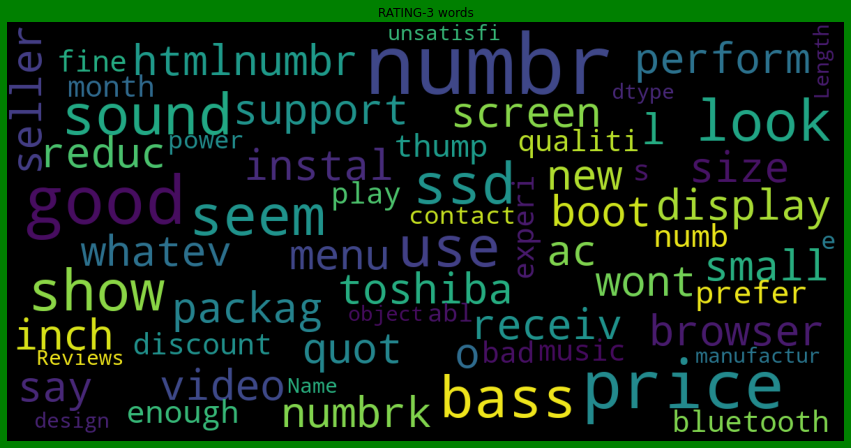

In [32]:
Display_wordcloud(ds_Final['Reviews'][ds_Final['Ratings']==3],"RATING-3")

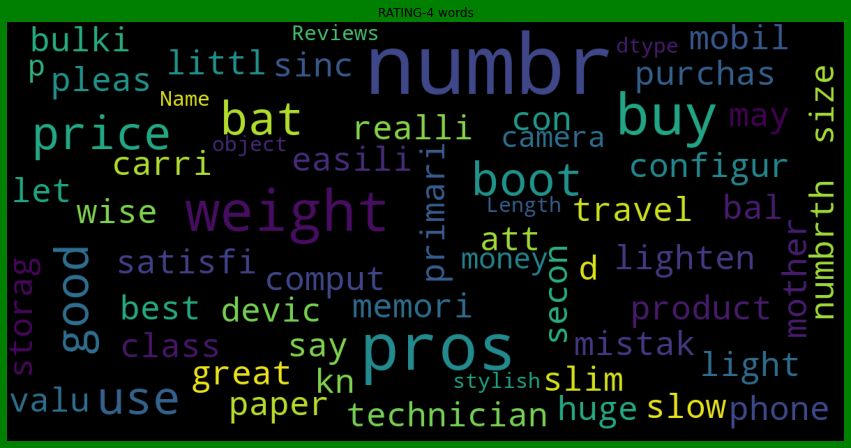

In [33]:
Display_wordcloud(ds_Final['Reviews'][ds_Final['Ratings']==4],"RATING-4")

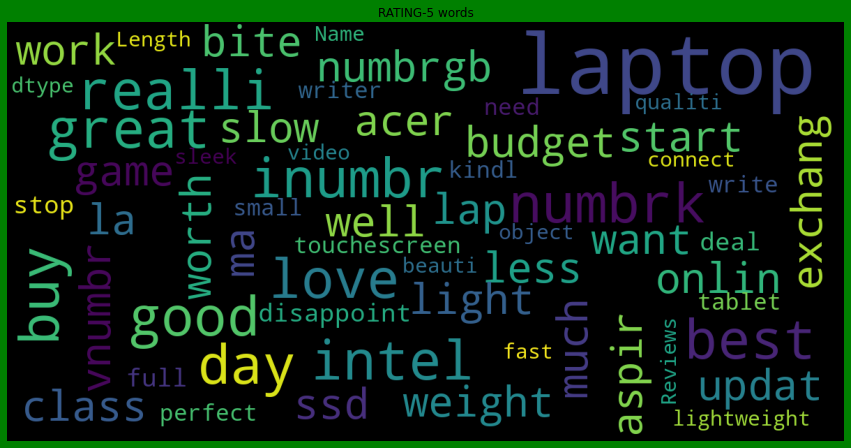

In [34]:
Display_wordcloud(ds_Final['Reviews'][ds_Final['Ratings']==5],"RATING-5")

# Model Building

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vec = TfidfVectorizer()
features = tf_vec.fit_transform(ds_Final['Reviews']) #Using tfidfvectorizer to vectorize the Review feature

X = features
y = ds_Final['Ratings']

print("X.shape = ",X.shape)
print("y.shape = ",y.shape)

X.shape =  (23700, 14981)
y.shape =  (23700,)


In [36]:
# Importing libraries for model training

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier



from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV


# Importing evaluation metrics for model performance.... 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

In [37]:
#splitting the data into training and testing
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.30,stratify=y)

In [38]:
# Creating instances for different Classifiers

RFC=RandomForestClassifier() 
ADA=AdaBoostClassifier()
MNB=MultinomialNB()
DT=DecisionTreeClassifier()
KNN=KNeighborsClassifier()
XGB=XGBClassifier()

In [39]:
# List of Models
models=[]

models.append(('MultinomialNB()',MNB))
models.append(('DecisionTreeClassifier',DT))
models.append(('KNeighborsClassifier',KNN))
models.append(('RandomForestClassifier',RFC))
models.append(('AdaBoostClassifier',ADA))
models.append(('XGBClassifier', XGB))

************** MultinomialNB() ***************


MultinomialNB()


Accuracy_score= 0.560196905766526


Cross_Val_Score= 0.39316455696202535


classification report
               precision    recall  f1-score   support

           1       0.60      0.67      0.64      1422
           2       0.61      0.35      0.45      1422
           3       0.55      0.37      0.45      1422
           4       0.52      0.63      0.57      1422
           5       0.54      0.77      0.64      1422

    accuracy                           0.56      7110
   macro avg       0.57      0.56      0.55      7110
weighted avg       0.57      0.56      0.55      7110



[[ 956  150   69   95  152]
 [ 358  498  204  183  179]
 [ 166  128  533  329  266]
 [  49   22  125  901  325]
 [  56   17   33  221 1095]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)



************** DecisionTreeClassifier ***************


DecisionTreeClassifier()


Accuracy_score= 0.6468354430379747


Cross_Val_Score= 0.4556540084388185

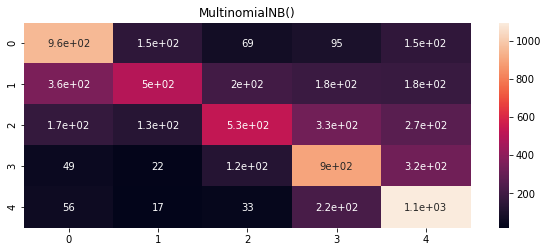

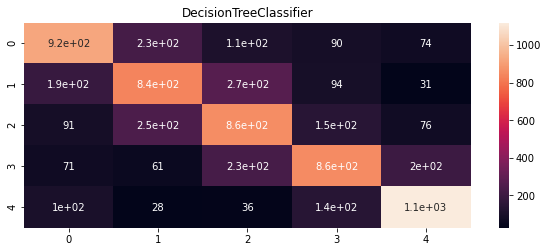

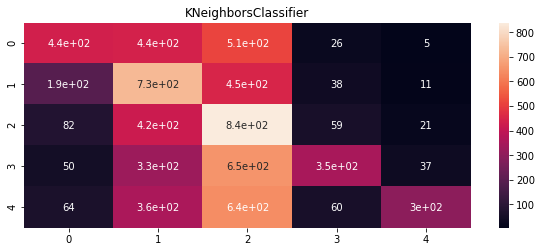

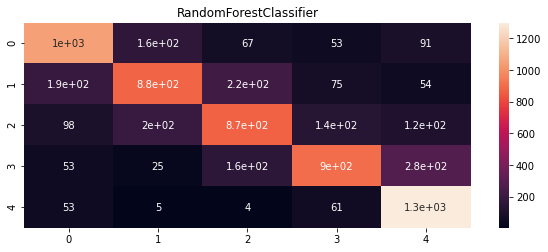

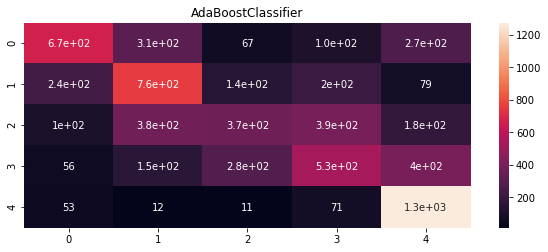

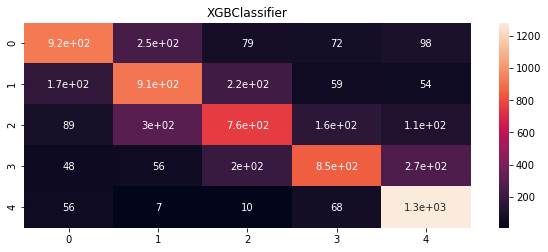

In [49]:
#creating a loop where each model will be taken and its corresponding accuracy score,cross validation score and classification 
                                                                                                     #report will be generated
Model=[]
score=[]
cvs=[]

for name,model in models:
    print('**************',name,'***************')
    print('\n')
    Model.append(name)
    model.fit(x_train,y_train)
    print(model)
    pre=model.predict(x_test)
    print('\n')
    AS=accuracy_score(y_test,pre)
    print('Accuracy_score=',AS)
    score.append(AS*100)
    print('\n')
    sc=cross_val_score(model,X,y,cv=5,scoring='accuracy').mean()
    print('Cross_Val_Score=',sc)
    cvs.append(sc*100)
    print('\n')
    print('classification report\n',classification_report(y_test,pre))
    print('\n')
    cm=confusion_matrix(y_test,pre)
    print(cm)
    print('\n')
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    print(sns.heatmap(cm,annot=True))
    #plt.subplot(912)
    #plt.title(name)
    print('\n\n')

# Model Summary

In [51]:
result=pd.DataFrame({'Model': Model,'Score': score,'Cross_Val_Score':cvs})
result

,Model,Score,Cross_Val_Score
0,MultinomialNB(),56.019691,39.316456
1,DecisionTreeClassifier,64.683544,45.565401
2,KNeighborsClassifier,37.313643,28.172996
3,RandomForestClassifier,70.239100,51.054852
4,AdaBoostClassifier,50.703235,41.805907
5,XGBClassifier,66.568214,48.046414


We are getting best parameters with Randomforest classifier so we choose this for hyper parameter tunning

In [52]:
RF=RandomForestClassifier()
RF.fit(x_train,y_train)
Predrf=RF.predict(x_test)
print(accuracy_score(y_test,Predrf))
print(confusion_matrix(y_test,Predrf))
print(classification_report(y_test,Predrf))

0.6997187060478199
[[1038  170   63   51  100]
 [ 190  867  218   84   63]
 [  97  198  858  150  119]
 [  54   22  148  922  276]
 [  52    6    2   72 1290]]
              precision    recall  f1-score   support

           1       0.73      0.73      0.73      1422
           2       0.69      0.61      0.65      1422
           3       0.67      0.60      0.63      1422
           4       0.72      0.65      0.68      1422
           5       0.70      0.91      0.79      1422

    accuracy                           0.70      7110
   macro avg       0.70      0.70      0.70      7110
weighted avg       0.70      0.70      0.70      7110



# Hyperparameter Tunning

In [53]:
#Performing Hyperparameter tuning on RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf=RandomForestClassifier()
parameters={'n_estimators':[50,100,150,200,250,300,350,400,450,500],'max_depth':[5, 8, 15, 25, 30]}
clf=GridSearchCV(rf,parameters,cv=5)
clf.fit(X,y)
clf.best_params_

{'max_depth': 30, 'n_estimators': 450}

In [54]:
#Applying the parameters we got after hyper parameter tuning
rf=RandomForestClassifier(n_estimators=450,max_depth=30)
rf.fit(x_train,y_train)
predrf=rf.predict(x_test)
print(accuracy_score(y_test,predrf))
print(confusion_matrix(y_test,predrf))
print(classification_report(y_test,predrf))

0.6526019690576652
[[ 912  310   58   54   88]
 [ 173  955  160   77   57]
 [  89  369  706  127  131]
 [  51   97  157  817  300]
 [  52   41   13   66 1250]]
              precision    recall  f1-score   support

           1       0.71      0.64      0.68      1422
           2       0.54      0.67      0.60      1422
           3       0.65      0.50      0.56      1422
           4       0.72      0.57      0.64      1422
           5       0.68      0.88      0.77      1422

    accuracy                           0.65      7110
   macro avg       0.66      0.65      0.65      7110
weighted avg       0.66      0.65      0.65      7110



After applying desired parameter we choose randomforest Classifier for our model

# Predicting Test Dataset

In [55]:
test_data=pd.DataFrame(data=y_test,)
test_data['Predicted values']=Predrf

test_data.to_csv('Ratings_Predict.csv')

test_data

,Ratings,Predicted values
10735,3,3
9775,3,5
20653,1,1
6730,4,2
15906,2,2
...,...,...
19149,1,1
23506,1,3
10472,3,2
20559,1,1


In [56]:
# Creating Pickle File
import joblib
joblib.dump(RF,'Ratings_Prediction_dataset.pkl')

['Ratings_Prediction_dataset.pkl']